# Batch correction

What is batch correction? A "Batch" is when experiments have been performed at different times and there's some obvious difference between them. Single-cell experiments are often inherently "batchy" because you can only perform so many single cell captures at once, and you do multiple captures, over different days, with different samples. How do you correct for the technical noise without deleting the true biological signal?

## Avoiding batch effects

First things first, it's best to design your experiments to minimize batch effects. For example, if you can mix your samples such that there are multiple representations of samples per single-cell capture, then this will help because you will have representations of both biological and technical variance across batches, rather than BOTH biological and technical variance.

![](figures/hicks_figure1.png)

### Bad: Technical variance is the same as biological variance

![Don't confound your biological and technical variance](figures/batch_effects-01.png)

Here, when you try to correct for batch effects between captures, it's impossible to know whether you're removing the technical noise of the different captures, or the biological signal of the data.

### Good: Technical variance is different from biological variance
The idea here is that you would ahead of time, mix the cells from your samples in equal proportions and then perform cell capture on the mixed samples, so you would get different technical batches, but they wouldn't be counfounded by the biological signals.

![Spread your biological signal across technical replicates](figures/batch_effects-02.png)

Here, when you correct for batch effects, the technical batches and biological signals are separate.

### If it's completely impossible to do multiple biological samples in the same technical replicate...

For example, if you have 

## Correcting batch effects
Okay so say your data are such that you couldn't have mixed your biological samples ahead of time. What do you do?


There's two main ways to approach batch correction: using groups of samples or groups of features (genes).

### Sample-batchy

This is when you have groups of samples that may have some biological difference between them, but also have technical differences between them. Say, you performed single-cell capture on several different days from different mice, of somewhat overlapping ages. You know that you have the biological signal from the different mice and the different ages, but you *also* have the technical signal from the different batches. BUT there's no getting around that you had to sacrifice the mice and collect their cells in one batch

### Feature-batchy

This is when you think particular groups of genes are contributing to the batch effects.

How to find these features:

* Numerical feature (e.g. RIN) associated with each sample
* Cell cycle genes (??Buetttner 2015?)
* (RUVseq) - Use an external dataset (e.g. bulk samples) to find non-differentially expressed genes and use them to correct between groups

In [1]:
from __future__ import print_function

# Interactive Python (IPython - now Jupyter) widgets for interactive exploration
import ipywidgets

# Numerical python library
import numpy as np

# PLotting library
import matplotlib.pyplot as plt

# Dataframes in python
import pandas as pd

# Linear model correction
import patsy 

# Even better plotting
import seaborn as sns

# Batch effect correction
# This import statement only works because there's a folder called "combat_py" here, not that there's a module installed
from combat_py.combat import combat


# Use the styles and colors that I like
sns.set(style='white', context='talk', palette='Set2')
%matplotlib inline

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Feature-batchy

In [2]:
np.random.seed(2016)

n_samples = 10
n_genes = 20

half_genes = int(n_genes/2)
half_samples = int(n_samples/2)
size = n_samples * n_genes

genes = ['Gene_{}'.format(str(i+1).zfill(2)) for i in range(n_genes)]
samples = ['Sample_{}'.format(str(i+1).zfill(2)) for i in range(n_samples)]

data = pd.DataFrame(np.random.randn(size).reshape(n_samples, n_genes), index=samples, columns=genes)

# Add biological variance
data.iloc[:half_samples, :half_genes] += 1
data.iloc[:half_samples, half_genes:] += -1
data.iloc[half_samples:, half_genes:] += 1
data.iloc[half_samples:, :half_genes] += -1

# Biological samples
mouse_groups = pd.Series(dict(zip(data.index, (['Mouse_01'] * int(n_samples/2)) + (['Mouse_02'] * int(n_samples/2)))), 
                         name="Mouse")
mouse_to_color = dict(zip(['Mouse_01', 'Mouse_02'], ['lightgrey', 'black']))
mouse_colors = [mouse_to_color[mouse_groups[x]] for x in samples]

# Gene colors
gene_colors = sns.color_palette('husl', n_colors=n_genes)

### Plot original biological variance data

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


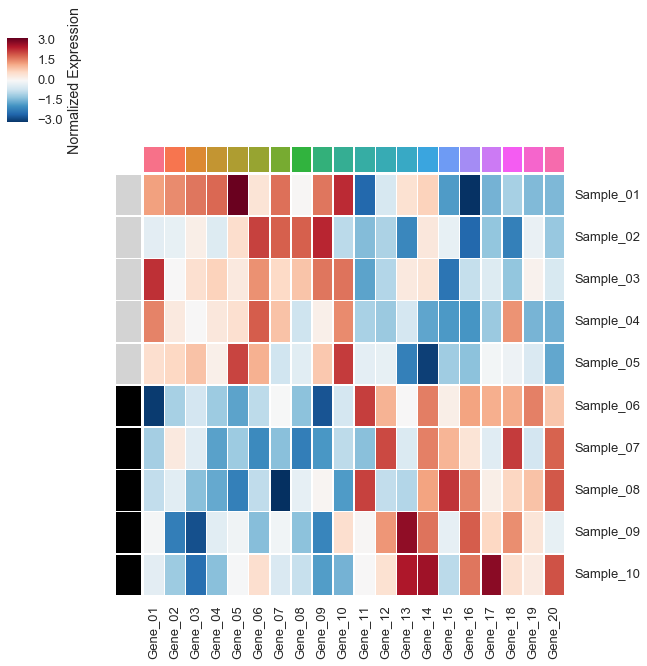

In [3]:
g = sns.clustermap(data, row_colors=mouse_colors, col_cluster=False, row_cluster=False, linewidth=0.5, 
                   col_colors=gene_colors,
                   cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

In [4]:
def make_tidy(data, sample_groups):
    tidy = data.unstack()
    tidy = tidy.reset_index()
    tidy = tidy.rename(columns={'level_0': 'Gene', 'level_1': "Sample", 0: "Normalized Expression"})
    tidy = tidy.join(sample_groups, on='Sample')
    return tidy

In [5]:
tidy = make_tidy(data, mouse_groups)

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


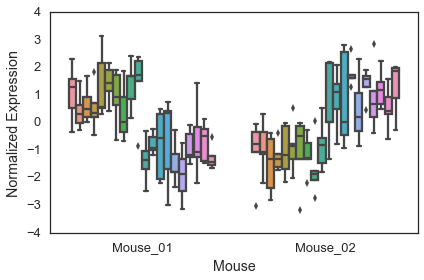

In [6]:
fig, ax = plt.subplots()
sns.boxplot(hue='Gene', y='Normalized Expression', data=tidy, x='Mouse')
ax.legend_.set_visible(False)

### Add technical noise

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


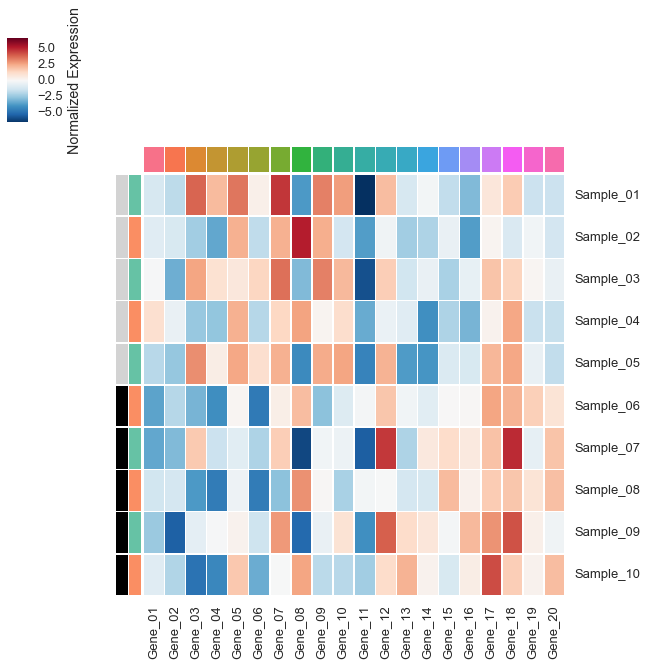

In [7]:
# Choose odd-numbered samples to be in batch1 and even numbered samples to be in batch 2
batch1_samples = samples[::2]
batch2_samples = data.index.difference(batch1_samples)
batches = pd.Series(dict((x, 'Batch_01') if x in batch1_samples else (x, "Batch_02") for x in samples), name="Batch")

# Add random noise for all genes except the last two in each batch
noisy_data = data.copy()
noisy_data.ix[batch1_samples, :-2] += np.random.normal(size=n_genes-2, scale=2)
noisy_data.ix[batch2_samples, :-2] += np.random.normal(size=n_genes-2, scale=2)


# Assign colors for batches
batch_to_color = dict(zip(["Batch_01", "Batch_02"], sns.color_palette()))
batch_colors = [batch_to_color[batches[x]] for x in samples]
row_colors = [mouse_colors, batch_colors]


g = sns.clustermap(noisy_data, row_colors=row_colors, col_cluster=False, row_cluster=False, linewidth=0.5, 
                   col_colors=gene_colors, cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

We can see that there's some batch effect - for batch1 (light grey), `Gene_15` is in general lower, and `Gene_01` is in general higher. And for batch2 (black), `Gene_16` is in general higher.

But, Gene_19 and Gene_20 are unaffected.

In [8]:
tidy_noisy = make_tidy(noisy_data, mouse_groups)
tidy_noisy = tidy_noisy.join(batches, on='Sample')
tidy_noisy.head()

,Gene,Sample,Normalized Expression,Mouse,Batch
0,Gene_01,Sample_01,-1.094191,Mouse_01,Batch_01
1,Gene_01,Sample_02,-0.826770,Mouse_01,Batch_02
2,Gene_01,Sample_03,-0.069040,Mouse_01,Batch_01
3,Gene_01,Sample_04,1.078731,Mouse_01,Batch_02
4,Gene_01,Sample_05,-1.856960,Mouse_01,Batch_01


Lets plot the boxplots of data the same way, with the x-axis as the mouse they came from and the y-axis ad the genes

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


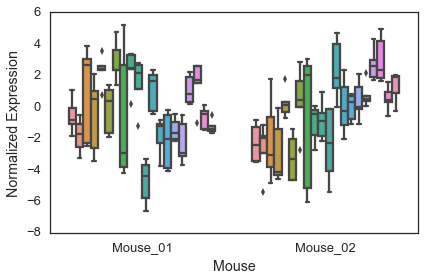

In [9]:
fig, ax = plt.subplots()
sns.boxplot(hue='Gene', y='Normalized Expression', data=tidy_noisy, x='Mouse')
ax.legend_.set_visible(False)

We can see that compared to before, where we had clear differences in gene expression from genes 1-10 and 11-19 in the two mice, we don't see it as much with the noisy data.

Now let's plot the data a different way, with the x-axis as the *batch*

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


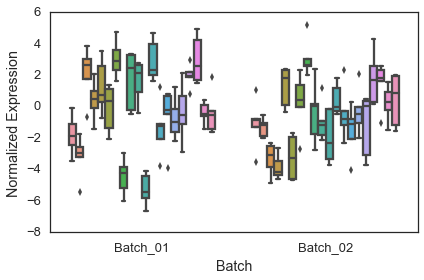

In [10]:
fig, ax = plt.subplots()
sns.boxplot(hue='Gene', y='Normalized Expression', data=tidy_noisy, x='Batch')
ax.legend_.set_visible(False)

## How to quantify the batch effect?

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


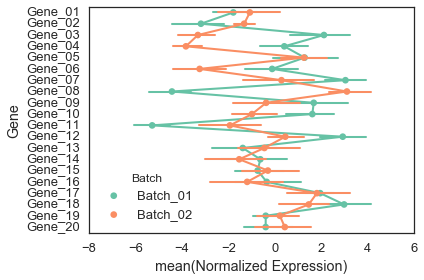

In [11]:
fig, ax = plt.subplots()
sns.pointplot(hue='Batch', x='Normalized Expression', data=tidy_noisy, y='Gene', orient='horizontal', 
              scale=0.5, palette=batch_colors)

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


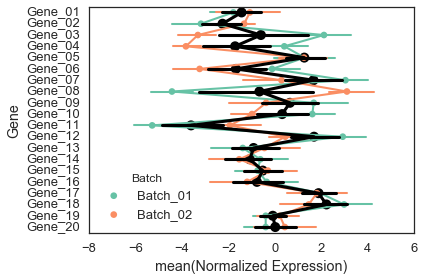

In [12]:
fig, ax = plt.subplots()
sns.pointplot(hue='Batch', x='Normalized Expression', data=tidy_noisy, y='Gene', orient='horizontal', scale=0.5)
sns.pointplot(x='Normalized Expression', data=tidy_noisy, y='Gene', orient='horizontal', scale=0.75, color='k', 
              linestyle=None)

## How to get rid of the batch effect?


### COMBAT
We will use "COMBAT" to get rid of the batch effect. What combat does is basically what we just did with our eyes and intuition - find genes whose gene expression varies greatly between batches, and adjust the expression of the gene so it's closer to the mean total expression across batches.


(may need to whiteboard here)

Create metadata matrix

In [13]:
metadata = pd.concat([batches, mouse_groups], axis=1)
metadata

,Batch,Mouse
Sample_01,Batch_01,Mouse_01
Sample_02,Batch_02,Mouse_01
Sample_03,Batch_01,Mouse_01
Sample_04,Batch_02,Mouse_01
Sample_05,Batch_01,Mouse_01
Sample_06,Batch_02,Mouse_02
Sample_07,Batch_01,Mouse_02
Sample_08,Batch_02,Mouse_02
Sample_09,Batch_01,Mouse_02
Sample_10,Batch_02,Mouse_02


/Users/olga/workspace-git/single-cell-bioinformatics/1._Introduction+Dealing_with_technical_noise/combat_py/combat.py:80: FutureWarning: iterkv is deprecated and will be removed in a future release, use ``iteritems`` instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iterkv() if inter == True]
found 2 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


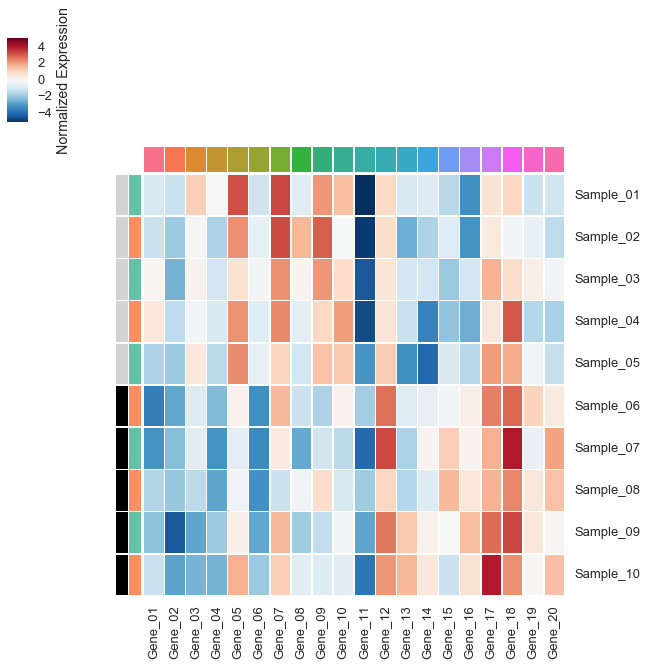

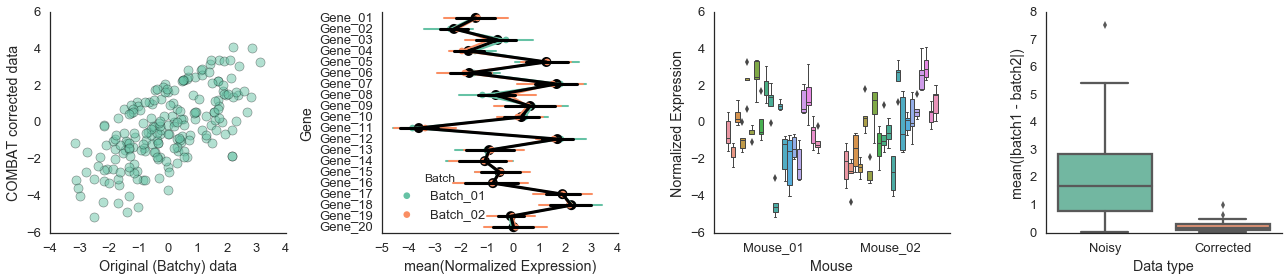

In [14]:

def remove_batch_effects_with_combat(batch, keep_constant=None, cluster_on_correlations=False):
    if keep_constant is not None or keep_constant in metadata:
        # We'll use patsy (statistical models in python) to create a "Design matrix" which encodes the batch as 
        # a boolean (0 or 1) value so the computer cna understand it.
        model = patsy.dmatrix('~ {}'.format(keep_constant), metadata, return_type="dataframe")
    elif keep_constant == 'null' or keep_constant is None:
        model = None
        
    # --- Correct for batch effects --- #
    corrected_data = combat(noisy_data.T, metadata[batch], model)
    
    # Transpose so samples are the rows and the features are the columns
    corrected_data = corrected_data.T

    # --- Plot the heatmap --- #
    if cluster_on_correlations:
        g = sns.clustermap(corrected_data.T.corr(), row_colors=row_colors, col_cluster=True, row_cluster=True, linewidth=0.5, 
                           vmin=-1, vmax=1, col_colors=row_colors, cbar_kws=dict(label='Pearson R'))
        plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);
    else:
        g = sns.clustermap(corrected_data, row_colors=row_colors, col_cluster=False, row_cluster=False, linewidth=0.5, 
                       col_colors=gene_colors, cbar_kws=dict(label='Normalized Expression'))
        plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);
        
    # Uncomment the line below to save the batch corrected heatmap
    # g.savefig('combat_batch_corrected_clustermap.pdf')
    
    # --- Quantification of the batch effect correction --- #
    # Create a "tidy" version of the dataframe for plotting
    tidy_corrected = make_tidy(corrected_data, mouse_groups)
    tidy_corrected = tidy_corrected.join(batches, on='Sample')
    tidy_corrected.head()

    # Set up the figure
    # 4 columns of figure panels
    figure_columns = 4
    width = 4.5 * figure_columns
    height = 4
    fig, axes = plt.subplots(ncols=figure_columns, figsize=(width, height))

    # PLot original data vs the corrected data
    ax = axes[0]
    ax.plot(data.values.flat, corrected_data.values.flat, 'o', 
            # Everything in the next line is my personal preference so it looks nice
            alpha=0.5, markeredgecolor='k', markeredgewidth=0.5)
    ax.set(xlabel='Original (Batchy) data', ylabel='COMBAT corrected data')

    # PLot the mean gene expression within batch in colors, and the mean gene expression across both batches in black
    ax = axes[1]
    sns.pointplot(hue='Batch', x='Normalized Expression', data=tidy_corrected, y='Gene', orient='horizontal', scale=.5, ax=ax)
    sns.pointplot(x='Normalized Expression', data=tidy_corrected, y='Gene', orient='horizontal', 
                  scale=0.75, color='k', linestyle=None, ax=ax)

    # PLot the gene epxression distribution per mouse
    ax = axes[2]
    sns.boxplot(hue='Gene', y='Normalized Expression', data=tidy_corrected, x='Mouse', ax=ax, 
                # Adjusting linewidth for my personal preference
                linewidth=1)
    # Don't show legend because it's too big
    ax.legend_.set_visible(False)
    
    
    # --- Plot boxplots of average difference between gene expression in batches --- #
    # Gete mean gene expression within batch for the original noisy data
    mean_batch_expression = noisy_data.groupby(batches).mean()
    noisy_batch_diff = (mean_batch_expression.loc['Batch_01'] - mean_batch_expression.loc['Batch_02']).abs()
    noisy_batch_diff.name = 'mean(|batch1 - batch2|)'
    noisy_batch_diff = noisy_batch_diff.reset_index()
    noisy_batch_diff['Data type'] = 'Noisy'

    # Get mean gene expression within batch for the corrected data
    mean_corrected_batch_expression = corrected_data.groupby(batches).mean()
    corrected_batch_diff = (mean_corrected_batch_expression.loc['Batch_01'] - mean_corrected_batch_expression.loc['Batch_02']).abs()
    corrected_batch_diff.name = 'mean(|batch1 - batch2|)'
    corrected_batch_diff = corrected_batch_diff.reset_index()
    corrected_batch_diff['Data type'] = 'Corrected'

    # Compile the two tables into one (concatenate)
    batch_differences = pd.concat([noisy_batch_diff, corrected_batch_diff])
    batch_differences.head()

    sns.boxplot(x='Data type', y='mean(|batch1 - batch2|)', data=batch_differences, ax=axes[3])

    # Remove right and top axes lines so it looks nicer
    sns.despine()

    # Magically adjust the figure panels (axes) so they fit nicely
    fig.tight_layout()

    # Uncomment the line below to save the figure of three panels
    # fig.savefig('combat_batch_corrected_panels.pdf')


ipywidgets.interact(
    remove_batch_effects_with_combat,
    batch=ipywidgets.Dropdown(options=['Mouse', 'Batch'], value="Batch", description='Batch to correct for'), 
    keep_constant=ipywidgets.Dropdown(value=None, options=[None, 'Mouse', 'Batch', 'Mouse + Batch'], 
                                      description='Variable of interest'),
    cluster_on_correlations=ipywidgets.Checkbox(value=False, description="Cluster on (Pearson) correlations between samples"));

Try doing these and see how they compare. Do you see similar trends to the original data? Do any of these create errors? Why would that be?

1. Batch to correct for = Batch, Variable of interest = Mouse
2. Batch to correct for = Mouse, Variable of interest = Batch
3. Batch to correct for = Batch, Variable of interest = Mouse + Batch
4. ... your own combinations!

With each of these try turning "Cluster on (Pearson) correlations between samples" on and off.

### How to quantify the improvement?

In [15]:
# Gete mean gene expression within batch for the original noisy data
mean_batch_expression = noisy_data.groupby(batches).mean()
noisy_batch_diff = (mean_batch_expression.loc['Batch_01'] - mean_batch_expression.loc['Batch_02']).abs()
noisy_batch_diff.name = 'mean(|batch1 - batch2|)'
noisy_batch_diff = noisy_batch_diff.reset_index()
noisy_batch_diff['Data type'] = 'Noisy'

# Get mean gene expression within batch for the corrected data
mean_corrected_batch_expression = corrected_data.groupby(batches).mean()
corrected_batch_diff = (mean_corrected_batch_expression.loc['Batch_01'] - mean_corrected_batch_expression.loc['Batch_02']).abs()
corrected_batch_diff.name = 'mean(|batch1 - batch2|)'
corrected_batch_diff = corrected_batch_diff.reset_index()
corrected_batch_diff['Data type'] = 'Corrected'

# Compile the two tables into one (concatenate)
batch_differences = pd.concat([noisy_batch_diff, corrected_batch_diff])
batch_differences.head()

fig, ax = plt.subplots()
sns.boxplot(x='Data type', y='mean(|batch1 - batch2|)', data=batch_differences)
sns.despine()

NameError: name 'corrected_data' is not defined

This is a nice way that we can visualize the improvement in reducing the batch-dependent signal.

## Feature-batchy

What if there are specific genes or features that are contributing to the batches?

This is the idea behind correcting for cell-cycle genes or some other feature that you know is associated with the data, e.g. the RNA Integrity Number (RIN).

Let's add some feature-batchy noise to our original data

In [16]:
metadata['RIN'] = np.arange( len(samples)) + 0.5
metadata

,Batch,Mouse,RIN
Sample_01,Batch_01,Mouse_01,0.5
Sample_02,Batch_02,Mouse_01,1.5
Sample_03,Batch_01,Mouse_01,2.5
Sample_04,Batch_02,Mouse_01,3.5
Sample_05,Batch_01,Mouse_01,4.5
Sample_06,Batch_02,Mouse_02,5.5
Sample_07,Batch_01,Mouse_02,6.5
Sample_08,Batch_02,Mouse_02,7.5
Sample_09,Batch_01,Mouse_02,8.5
Sample_10,Batch_02,Mouse_02,9.5


Add noise and plot it

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


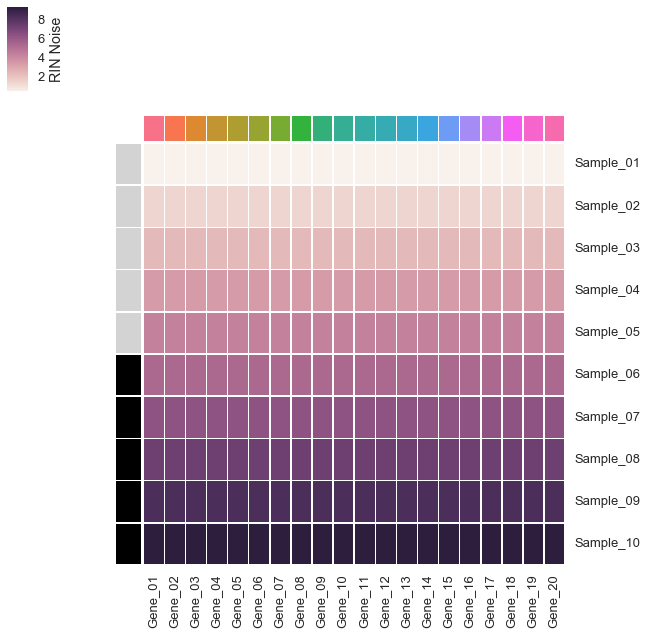

In [17]:
# rin_noise = metadata['RIN'].apply(lambda x: pd.Series(np.random.normal(loc=x, size=n_genes), index=genes))
rin_noise = metadata['RIN'].apply(lambda x: pd.Series(np.ones(n_genes)*x, index=genes))

g = sns.clustermap(rin_noise, row_colors=mouse_colors, col_cluster=False, row_cluster=False, linewidth=0.5, 
                   col_colors=gene_colors, cbar_kws=dict(label='RIN Noise'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

In [18]:
rin_batchy_data = data + rin_noise
rin_batchy_data

,Gene_01,Gene_02,Gene_03,Gene_04,Gene_05,Gene_06,Gene_07,Gene_08,Gene_09,Gene_10,Gene_11,Gene_12,Gene_13,Gene_14,Gene_15,Gene_16,Gene_17,Gene_18,Gene_19,Gene_20
Sample_01,1.794854,2.008038,2.204740,2.326131,3.635452,0.932162,2.235234,0.530005,2.194236,2.871332,-2.001542,-0.033502,0.982768,1.230708,-1.304407,-2.634575,-0.999264,-0.552567,-0.901678,-0.915155
Sample_02,1.160539,1.245233,1.698924,1.066033,2.052069,3.673166,3.404257,3.382609,3.911848,0.643834,0.122917,0.494370,-0.561288,1.849114,1.230049,-0.996900,0.239727,-0.677918,1.262050,0.302143
Sample_03,4.820004,2.501662,2.999247,3.225297,2.803212,3.945848,3.131389,3.414565,4.202688,4.217620,0.803064,1.565083,2.820987,2.924356,0.175061,1.739596,2.070879,1.242900,2.624048,1.986696
Sample_04,5.066040,3.798545,3.501921,3.858324,4.016710,5.421716,4.433272,2.833209,3.682335,5.002452,2.481885,2.312502,2.940893,1.826083,1.689834,1.626394,2.321908,4.927961,2.027469,1.970167
Sample_05,5.032085,5.153773,5.434329,4.693449,6.644750,5.637316,3.860453,4.138970,5.353104,6.719688,4.201174,4.251343,2.320605,1.519320,3.371908,3.192264,4.413204,4.327492,4.012260,2.865168
Sample_06,2.461386,4.437684,4.909338,4.358972,3.808295,4.665105,5.491590,4.189698,2.754156,4.938964,7.683631,6.605610,5.502570,7.125510,5.715307,6.776981,6.641508,6.669814,7.089756,6.388425
Sample_07,5.431199,6.798408,6.118723,4.787864,5.337284,4.490158,5.162541,4.314538,4.646350,5.678542,5.185247,8.593834,6.038551,8.103268,7.566466,6.942561,6.120464,8.721187,5.908624,8.374639
Sample_08,6.719255,7.145601,6.179223,5.886855,5.329701,6.703606,4.329532,7.218426,7.553691,5.696193,9.666440,6.732038,6.568958,8.780355,9.799755,9.065065,7.717609,8.187583,8.429965,9.479268
Sample_09,8.445657,6.298604,5.701884,8.130144,8.361061,7.159759,8.382973,7.198494,6.396773,9.037903,8.537393,9.891409,11.307274,10.227758,8.207269,10.411238,9.162980,9.962927,8.913666,8.240204
Sample_10,9.170980,8.344346,7.120529,8.170747,9.472426,10.037407,9.021687,8.769359,7.732210,8.013152,9.507172,9.976991,12.069862,12.182477,8.650453,11.206732,12.359435,10.009361,9.795474,11.530723


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


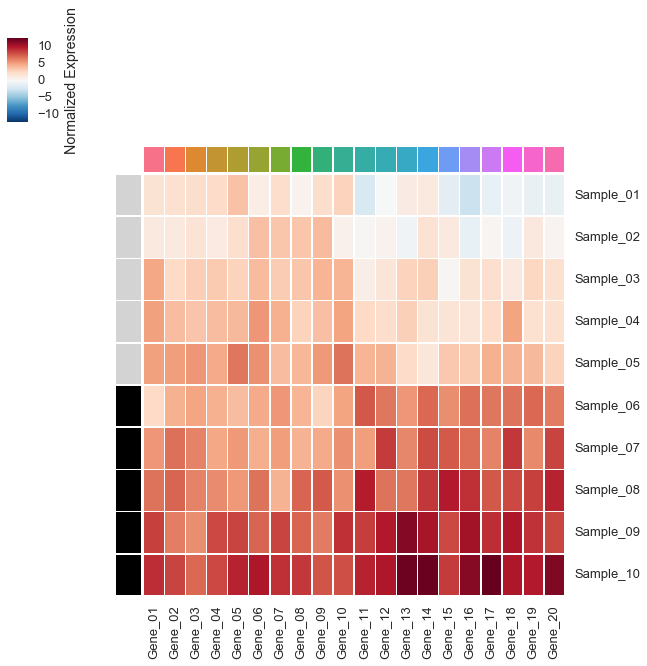

In [19]:
g = sns.clustermap(rin_batchy_data, row_colors=mouse_colors, col_cluster=False, row_cluster=False, linewidth=0.5, 
                   col_colors=gene_colors, cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

In [20]:
rin_batchy_model = patsy.dmatrix('~ RIN + Mouse', metadata, return_type='dataframe')
rin_batchy_model

,Intercept,Mouse[T.Mouse_02],RIN
Sample_01,1.0,0.0,0.5
Sample_02,1.0,0.0,1.5
Sample_03,1.0,0.0,2.5
Sample_04,1.0,0.0,3.5
Sample_05,1.0,0.0,4.5
Sample_06,1.0,1.0,5.5
Sample_07,1.0,1.0,6.5
Sample_08,1.0,1.0,7.5
Sample_09,1.0,1.0,8.5
Sample_10,1.0,1.0,9.5


In [21]:
combat??

In [22]:
# Doesn't work
# combat(rin_batchy_data.T, np.ones(n_samples), rin_batchy_model, numerical_covariates='RIN')

In [23]:
# regressor.residues_

If this feels familiar to you, that's good! "feature-batchy" and "sample-batchy" are really two sides of the same coin. On the one hand you say that samples are part of specific groups that contribute to differences in gene expression, and on the other hand, you say that samples express genes or have numeric features that contribute to differences in gene expression.

In [24]:
tidy_rin_batchy = make_tidy(rin_batchy_data, mouse_groups)
tidy_rin_batchy = tidy_rin_batchy.join(metadata['RIN'], on='Sample')
tidy_rin_batchy.head()

,Gene,Sample,Normalized Expression,Mouse,RIN
0,Gene_01,Sample_01,1.794854,Mouse_01,0.5
1,Gene_01,Sample_02,1.160539,Mouse_01,1.5
2,Gene_01,Sample_03,4.820004,Mouse_01,2.5
3,Gene_01,Sample_04,5.066040,Mouse_01,3.5
4,Gene_01,Sample_05,5.032085,Mouse_01,4.5


If we plot the RIN vs the RIN-batchy gene expression, we'll see that from this one variable, we see an increase in expression! Of course, we could also have created a variable that linearly decreases expression. 

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


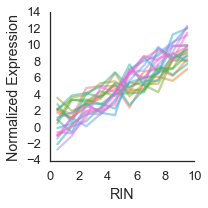

In [25]:
g = sns.FacetGrid(tidy_rin_batchy, hue='Gene')
g.map(plt.plot, 'RIN', 'Normalized Expression', alpha=0.5)

### Use RIN to predict gene expression

We will use linear regression to use RIN as our dependent variable and predict gene expression from there. This will 

In [26]:
rin_mouse_design = patsy.dmatrix('~ 1 + RIN', metadata, return_type='dataframe')
rin_mouse_design

,Intercept,RIN
Sample_01,1.0,0.5
Sample_02,1.0,1.5
Sample_03,1.0,2.5
Sample_04,1.0,3.5
Sample_05,1.0,4.5
Sample_06,1.0,5.5
Sample_07,1.0,6.5
Sample_08,1.0,7.5
Sample_09,1.0,8.5
Sample_10,1.0,9.5


In [27]:
combat(rin_batchy_data.T, metadata["RIN"], rin_mouse_design, numerical_covariates='RIN')

Adjusting data


/Users/olga/workspace-git/single-cell-bioinformatics/1._Introduction+Dealing_with_technical_noise/combat_py/combat.py:80: FutureWarning: iterkv is deprecated and will be removed in a future release, use ``iteritems`` instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iterkv() if inter == True]
found 10 batches
found 1 numerical covariates...
	RIN
found 0 categorical variables:	
Standardizing Data across genes.
/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
Fitting L/S model and finding priors
Finding parametric adjustments


,Sample_01,Sample_02,Sample_03,Sample_04,Sample_05,Sample_06,Sample_07,Sample_08,Sample_09,Sample_10
Gene_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/sklearn/metrics/regression.py:471: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value, it will be changed to 'uniform_average' in 0.18.
  DeprecationWarning)
/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/sklearn/metrics/regression.py:471: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value, it will be changed to 'uniform_average' in 0.18.
  DeprecationWarning)


Explained variance by RIN: 0.900142529735


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


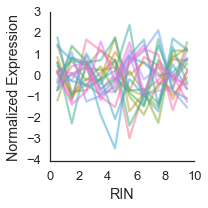

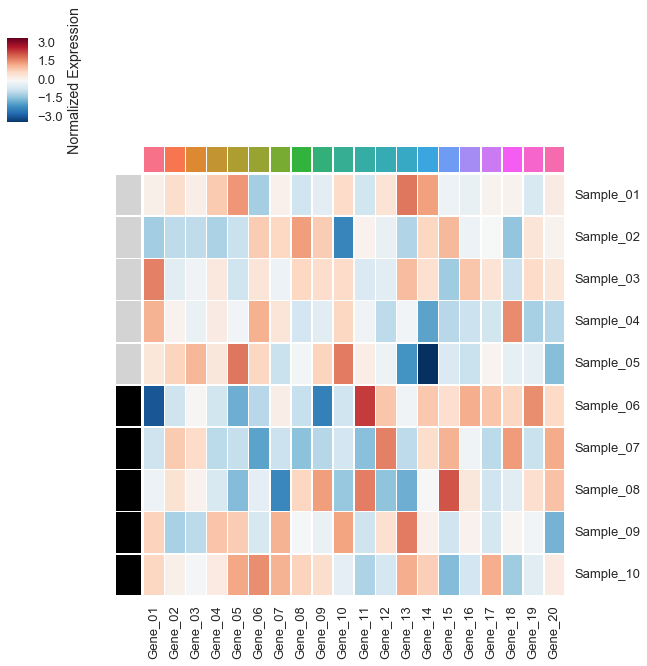

In [28]:
from __future__ import print_function
import six
from sklearn import linear_model

regressor = linear_model.LinearRegression()
regressor

# Use RIN as the "X" - the "dependent" variable, the one you expect your gene expression to vary with.

regressor.fit(metadata['RIN'].to_frame(), rin_batchy_data)

# Use RIN to predict gene expression as you used before

rin_dependent_data = pd.DataFrame(regressor.predict(metadata['RIN'].to_frame()), columns=genes, index=samples)
rin_dependent_data

from sklearn.metrics import r2_score

explained_variance = r2_score(rin_batchy_data, rin_dependent_data)
six.print_("Explained variance by RIN:", explained_variance)

rin_corrected_data = rin_batchy_data - rin_dependent_data
rin_corrected_data

# Somewhat contrived, but try to predict the newly corrected data with RIN

r2_score(rin_corrected_data, rin_dependent_data)

tidy_rin_corrected = make_tidy(rin_corrected_data, mouse_groups)
tidy_rin_corrected = tidy_rin_corrected.join(metadata['RIN'], on="Sample")
tidy_rin_corrected.head()

g = sns.FacetGrid(tidy_rin_corrected, hue='Gene')
g.map(plt.plot, 'RIN', 'Normalized Expression', alpha=0.5)

g = sns.clustermap(rin_corrected_data, row_colors=mouse_colors, col_cluster=False, row_cluster=False, linewidth=0.5, 
                   col_colors=gene_colors, cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


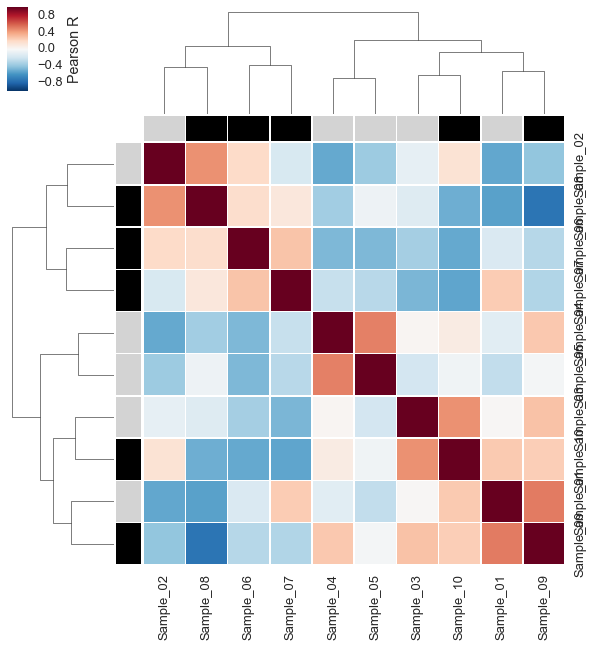

In [29]:
sns.clustermap(rin_corrected_data.T.corr(), row_colors=mouse_colors,linewidth=0.5, 
                   col_colors=mouse_colors, cbar_kws=dict(label='Pearson R'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

Now the data dcoens't vary by RIN!

Keep in mind that while we did this for a single feature, you could also take a subset of genes that you expect to vary

In [ ]:
(data - rin_batchy_data).abs().sum()

In [ ]:
(data - rin_corrected_data).abs().sum()